<br>

# Clustering Algorithms
---

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png" width=800 height=700></img>

<br>

## Cluster a set of documents by Topic / Theme using Python. 
---

<big>

Our motivation is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list)

We will attempt to cover

- Tokenizing
- Stemming
- Transforming the corpus into **vector space** using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
- Calculating cosine distance between each document as a **measure of similarity**
- Clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
- Using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
- Plotting the clustering output using [matplotlib](http://matplotlib.org/) 
- Conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
- Plotting a Ward dendrogram
- Topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

<br>

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

In [ ]:
with open('../data/synopses_list_imdb.txt', 'r') as f:
    synopses = f.read()

with open('../data/title_list.txt', 'r') as f:
    titles = f.read().split('\n')

with open('../data/genres_list.txt', 'r') as f:
    genres = f.read().split('\n')

dict_movies_and_synopsis = {
    title: text.replace("\n", '').strip()  
    for title,text 
    in zip(titles, synopses.split("BREAKS HERE"))
    if len(text.replace("\n", '').strip()) > 1
}

In [67]:
pd.Series(dict_movies_and_synopsis, name='Synopsis').to_frame().sample(10)

,Synopsis
Pulp Fiction,"Late one morning in the Hawthorne Grill, a res..."
Rocky,"Philadelphia Pennsylvania, home to the number ..."
Star Wars,Note: Italicized paragraphs denote scenes adde...
Doctor Zhivago,A high ranking Russian General has arrived at ...
Gandhi,The story begins with the assassination of Moh...
Double Indemnity,Walter Neff (MacMurray) is a successful insura...
Nashville,The overarching plot takes place over five day...
The Bridge on the River Kwai,[this synopsis is primarily from the wikipedia...
"The Good, the Bad and the Ugly",The film tells the story of three men who purs...
The Graduate,The film explores the life of 21-year-old Ben ...


---
## Getting a list of Stopwords

<big>

- First, load [NLTK's](http://www.nltk.org/) list of English stop words. 
- [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning
- As a matter of practice, we **remove** stop-words from a corpus before starting to analyze it

<br>

In [7]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

nltk.download('stopwords', )

[nltk_data] Downloading package stopwords to /Users/dush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stopwords = nltk.corpus.stopwords.words('english')

In [69]:
print(stopwords[:10])

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


---

## Stemming: Getting to the root of words

<big> 
    
- Import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK
- [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root
    - For example: removing -ing and -ization etc.

Below we define two functions:

- `tokenize_and_stem`: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token 
- `tokenize_only`: tokenizes the synopsis only

We both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes.

<br>


In [10]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [11]:
def tokenize_only(text):
    """
    """
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [12]:
def tokenize_and_stem(text):
    """
    """
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [13]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /Users/dush/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [14]:
text_1 = "Tessio is driven away and never seen again (it is implied that Cicci shoots and kills Tessio with his own gun after he disarms him prior to entering the car)"
print(tokenize_only(text_1))

['tessio', 'is', 'driven', 'away', 'and', 'never', 'seen', 'again', 'it', 'is', 'implied', 'that', 'cicci', 'shoots', 'and', 'kills', 'tessio', 'with', 'his', 'own', 'gun', 'after', 'he', 'disarms', 'him', 'prior', 'to', 'entering', 'the', 'car']


In [15]:
print(tokenize_and_stem(text_1))

['tessio', 'is', 'driven', 'away', 'and', 'never', 'seen', 'again', 'it', 'is', 'impli', 'that', 'cicci', 'shoot', 'and', 'kill', 'tessio', 'with', 'his', 'own', 'gun', 'after', 'he', 'disarm', 'him', 'prior', 'to', 'enter', 'the', 'car']


In [70]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in dict_movies_and_synopsis.values():
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

<br>

<big>

Using these two lists, let's create a pandas DataFrame

- with the stemmed vocabulary as the index and 
- the tokenized words as the column. 

This provides an efficient way to look up a stem and return a full token. 

The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. 

<br>

In [71]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [72]:
vocab_frame.shape

(147591, 1)

In [73]:
vocab_frame.sample(10)

,words
the,the
of,of
success,success
day,day
with,with
gaear,gaear
to,to
'd,'d
in,in
the,the


<br>

## Tf-idf and Document Similarity
---

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

<big>

- Here, I define **term frequency - inverse document frequency** (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

- To get a Tf-idf matrix, first count word occurrences by document. 
    - This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix.

- Then apply the term frequency-inverse document frequency weighting

> Words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters below:

- `max_df`: this is the maximum frequency within the documents a given feature can have to be used in the tf-idf matrix.
    - If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
- `min_idf`: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered.
    - Here if we pass `0.2`; the term must be in at least 20% of the documents. If we allowed a lower min_df we end up getting common names - for example "Michael" or "Tom" are found in several movies and the synopses use these names frequently, but the names carry no real meaning.
- `ngram_range`: this just means I'll look at unigrams, bigrams and trigrams. 
    - See [n-grams](http://en.wikipedia.org/wiki/N-gram)
    - These are useful for context - words within phrases could have negations or different meanings

<br>

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                   max_features=200000,
                                   min_df=0.2, 
                                   stop_words=stopwords,
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem, 
                                   ngram_range=(1,3))

#fit the vectorizer to synopses
tfidf_matrix = tfidf_vectorizer.fit_transform(dict_movies_and_synopsis.values()) 

/Users/dush/Code/cst4150/.fintech/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dush/Code/cst4150/.fintech/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


In [75]:
print(tfidf_matrix.shape)

(90, 495)


In [76]:
terms = tfidf_vectorizer.get_feature_names_out()

In [77]:
terms[:20]

array(["'d", "'s father", 'abandon', 'abl', 'accept', 'accid',
       'accompani', 'across', 'act', 'action', 'admit', 'afterward',
       'agre', 'air', 'aliv', 'allow', 'alon', 'along', 'alreadi', 'also'],
      dtype=object)

In [78]:
len(terms)

495

In [79]:
pd.Series(dict_movies_and_synopsis).head()

The Godfather               In late summer 1945, guests are gathered for t...
The Shawshank Redemption    In 1947, Andy Dufresne (Tim Robbins), a banker...
Schindler's List            The relocation of Polish Jews from surrounding...
Raging Bull                 The film opens in 1964, where an older and fat...
Casablanca                  In the early years of World War II, December 1...
dtype: object

In [86]:
df_tfidf = \
pd.DataFrame(data=tfidf_matrix.toarray(), 
             columns=terms, 
             index=dict_movies_and_synopsis.keys())

df_tfidf

,'d,'s father,abandon,abl,accept,accid,accompani,across,act,action,...,word,work,world,world war,would,wound,write,year,york,young
The Godfather,0.022445,0.0,0.000000,0.000000,0.020930,0.000000,0.022445,0.000000,0.019324,0.000000,...,0.000000,0.000000,0.019934,0.024250,0.044210,0.000000,0.000000,0.077465,0.000000,0.067019
The Shawshank Redemption,0.096577,0.0,0.000000,0.045029,0.000000,0.000000,0.000000,0.000000,0.020787,0.025069,...,0.025565,0.113840,0.021443,0.000000,0.095115,0.000000,0.050138,0.049998,0.000000,0.018023
Schindler's List,0.000000,0.0,0.000000,0.045705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.057775,0.087061,0.052955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Raging Bull,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.052795,0.046890,0.000000,0.000000,...,0.055901,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109330,0.051849,0.000000
Casablanca,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.068971,0.038391,0.115705,0.070378,0.042769,0.000000,0.067633,0.044964,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Double Indemnity,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.041621,0.000000,0.000000,0.000000,0.070618,0.000000,0.000000,0.000000,0.000000
Rebel Without a Cause,0.000000,0.0,0.048775,0.000000,0.000000,0.049770,0.000000,0.000000,0.079321,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047829,0.031798,0.000000,0.000000
Rear Window,0.036699,0.0,0.000000,0.000000,0.000000,0.000000,0.036699,0.130376,0.000000,0.000000,...,0.038859,0.021630,0.000000,0.000000,0.048192,0.000000,0.000000,0.000000,0.036042,0.000000
The Third Man,0.015921,0.0,0.000000,0.000000,0.029692,0.086006,0.015921,0.028280,0.013707,0.000000,...,0.000000,0.028150,0.000000,0.000000,0.073173,0.015921,0.016530,0.000000,0.000000,0.000000


<br>

### Cosine Similarity
---

<big>

- Distance `dist` is defined as `1 - cosine similarity` of each document. 
- Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses)
- Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.
- Note that with *dist* it is possible to evaluate the similarity of any two or more synopses.

<br>

In [81]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [82]:
import seaborn as sns

<Axes: >

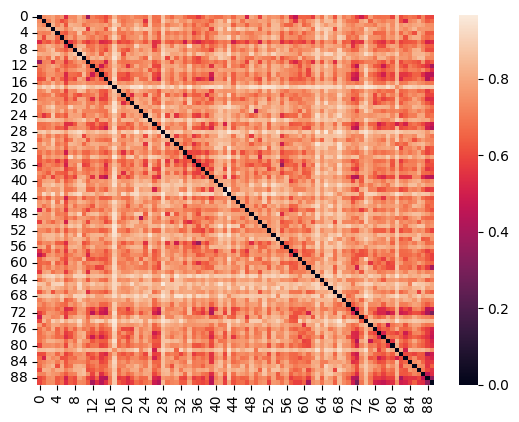

In [83]:
sns.heatmap(pd.DataFrame(dist))

# K-means clustering

<big>

- Using the tf-idf matrix, you can run a clustering algorithm to better understand the structure within the synopses 
- Let's start with [k-means](http://en.wikipedia.org/wiki/K-means_clustering).
    - K-means initializes with a pre-determined number of clusters (I chose 5).
    - Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares.
    - Next, the mean of the clustered observations is calculated and used as the new cluster centroid.
    - Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

<br>

In [84]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [91]:
df_clustered = \
(pd.DataFrame(data=dict_movies_and_synopsis.values(), 
             index=dict_movies_and_synopsis.keys(), columns=['Synopsis'])
 .join(pd.Series(data=clusters, index=dict_movies_and_synopsis.keys(), name='Cluster'))
)

In [101]:
sns.set_style('darkgrid')
sns.set_context('notebook')

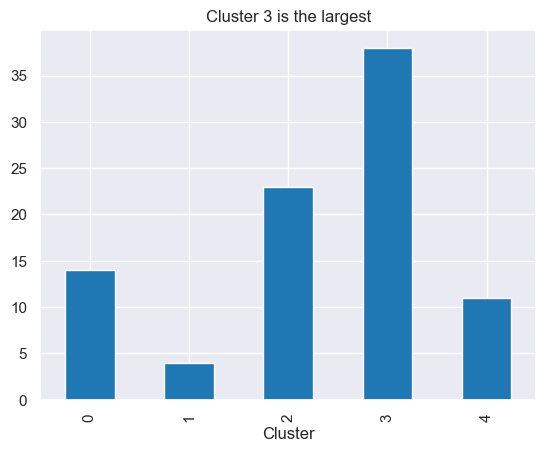

In [104]:
df_clustered.loc[:, 'Cluster'].value_counts().sort_index().plot.bar(title='Cluster 3 is the largest');

Here is some code to convert the dist matrix into a 2-dimensional array using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling). I won't pretend I know a ton about MDS, but it was useful for this purpose. Another option would be to use [principal component analysis](http://en.wikipedia.org/wiki/Principal_component_analysis). 

In [119]:
from sklearn.manifold import MDS

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

/Users/dush/Code/cst4150/.fintech/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


# Visualizing document clusters

In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js). 

First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [122]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

Next, I plot the labeled observations (films, film titles) colored by cluster using matplotlib. I won't get into too much detail about the matplotlib plot, but I tried to provide some helpful commenting.

In [125]:
df = pd.DataFrame(dict(x=xs, y=ys, label=df_clustered['Cluster'].values, title=df_clustered.index)) 

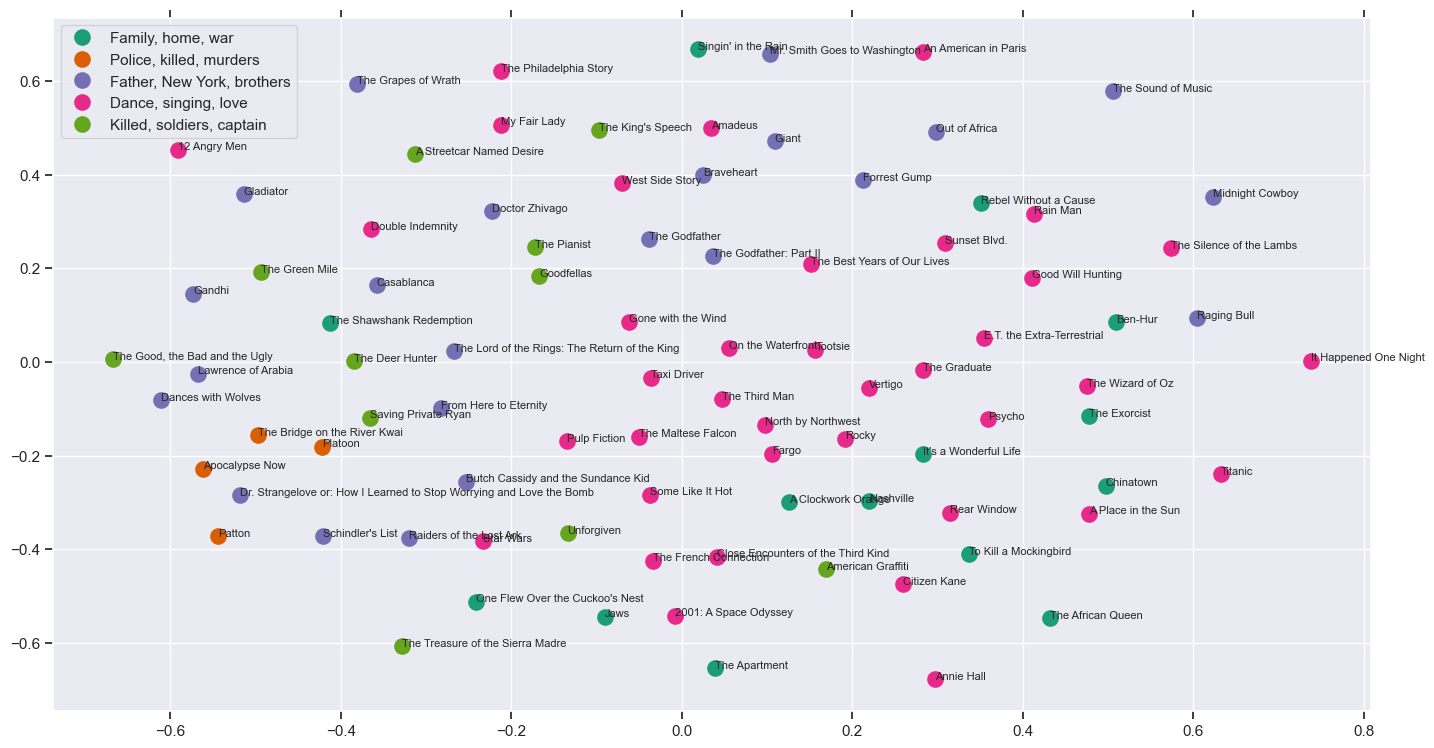

In [127]:
#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)